# Week 5 - Classifying Meanings & Documents

Recall that Week 1 of this course focused on how to find and extract text data, while weeks 2 through 4 each covered a different type of content representations:

2. computational linguistics (e.g., keyword count)
3. clustering and topic modeling (e.g., LDA)
4. embeddings (e.g., _word2vec_)

Now we show how classification, arguably the most common social science task, can be done with different representations. Note that the second representation, *clustering*, allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. Classification, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

We will show how to use a variety of classification methods, including Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip
#For ML
import sklearn
# import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

# Annotations

This is a course on "computational" content analysis, but the best computer today is arguably still the human brain. Our aim is to augment human intelligence and scholarship. One of the most important strategies is to have real, live _Homo sapiens_ annotate text, assigning numbers or categories to individual texts. We can computationally compare annotations across humans, and we can use annotations to train computational models.

Let's take a quick look at Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" alt="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" style="width:500px">

In [2]:
# Remember if you are on Google Colab, you need to upload or `git clone` the datafile
# and your path will probably be something like "#content/drive/MyDrive//data/pyAnno/testdata_numerical.txt"
x = np.loadtxt("../data/pyAnno/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [3]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [4]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [5]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [6]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[ 8.  7.  3.  2.]
 [ 9. 30. 13.  3.]
 [ 2.  9. 42. 11.]
 [ 1.  7. 14. 39.]]


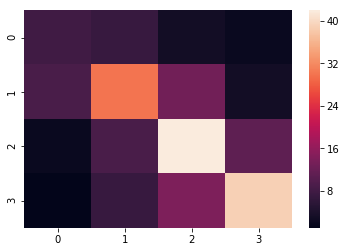

In [7]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [8]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4386478265891502

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [9]:
fleiss_kappa(anno.annotations[::])

0.40417653771912765

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [10]:
krippendorffs_alpha(anno.annotations[::])

0.6472588223831547

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [11]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

In [12]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.43917037 0.47677621        nan        nan        nan
  0.45819119 0.43381462]
 [0.43917037 1.         0.38432922 0.41344423        nan        nan
         nan 0.33643611]
 [0.47677621 0.38432922 1.         0.39583333 0.51704894        nan
         nan        nan]
 [       nan 0.41344423 0.39583333 1.         0.34597068 0.4446844
         nan        nan]
 [       nan        nan 0.51704894 0.34597068 1.         0.37938644
  0.43039733        nan]
 [       nan        nan        nan 0.4446844  0.37938644 1.
  0.38341929 0.31214748]
 [0.45819119        nan        nan        nan 0.43039733 0.38341929
  1.         0.394806  ]
 [0.43381462 0.33643611        nan        nan        nan 0.31214748
  0.394806   1.        ]]


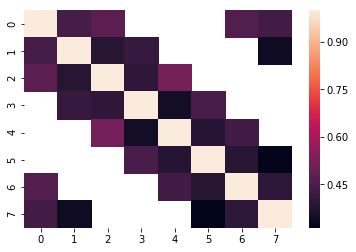

In [13]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others. 

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [14]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [15]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5330240507874497

Or averaged over the total:

In [16]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5299113458717166

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

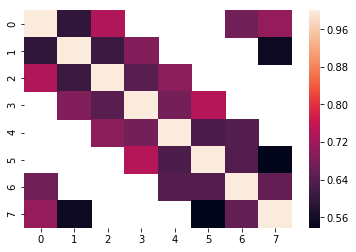

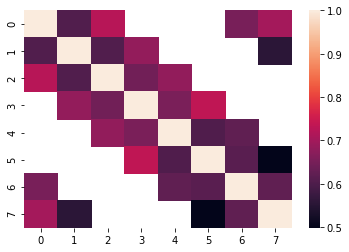

In [17]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [18]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.6517219321175077 0.63808488688039


## <font color="red">*Exercise 1*</font>

<font color="red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the [MTurk slides on Canvas](https://canvas.uchicago.edu/courses/39937/files/6674661?wrap=1), or by hand with friends.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

<font color = purple size = 2>I chose 7 news briefs about election from several Taiwanese media of different political inclinations, and then I ask 7 of my friends to label those paragraphs as pro-KMT, pro-DDP, or neutral. I hand coded the surveu result as the X array.<font/>
<font color = purple size = 2> 
    
Note: Taiwan has a 2-party political ecology: KMT is the pro-China party and DPP is the pro-independence party.

0: 泛藍 (KMT) 1:中立 (Neutral) 2:泛綠(DPP)

In [54]:
x = np.array([[2, 1, 0, 0, 0, 1, 1],
       [0, 1, 2, 0, 1, 1, 2],
       [2, 2, 0, 0, 0, 1, 0],
       [0, 1, 1, 1, 1, 1, 1],
       [0, 1, 0, 0, 1, 1, 0],
       [0, 1, 2, 0, 1, 2, 0],
       [0, 1, 0, 1, 1, 1, 2]])
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

In [56]:
anno.labels

[0, 1, 2]

In [58]:
pyanno.measures.agreement.labels_frequency(anno.annotations,3)

array([0.3877551 , 0.44897959, 0.16326531])

[[0. 5. 0.]
 [0. 0. 0.]
 [0. 1. 1.]]


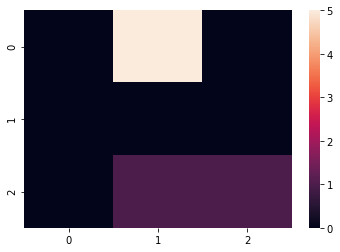

In [61]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],3)
print(c)
ac = seaborn.heatmap(c)
plt.show()

In [62]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

-0.33333333333333326

In [63]:
fleiss_kappa(anno.annotations[::])

-0.018096514745308385

In [64]:
krippendorffs_alpha(anno.annotations[::])

-0.0782029950083194

In [65]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.10638297872340426

In [66]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[ 1.          0.10638298 -0.4        -0.16666667 -0.25641026 -0.04255319
  -0.16666667]
 [ 0.10638298  1.         -0.02439024  0.05405405  0.26315789 -0.16666667
   0.        ]
 [-0.4        -0.02439024  1.          0.22222222  0.22222222  0.14634146
   0.32258065]
 [-0.16666667  0.05405405  0.22222222  1.          0.27586207  0.05405405
   0.3       ]
 [-0.25641026  0.26315789  0.22222222  0.27586207  1.         -0.10526316
  -0.06060606]
 [-0.04255319 -0.16666667  0.14634146  0.05405405 -0.10526316  1.
   0.        ]
 [-0.16666667  0.          0.32258065  0.3        -0.06060606  0.
   1.        ]]


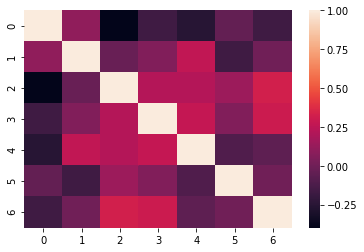

In [67]:
ax = seaborn.heatmap(m)
plt.show()

In [68]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.027507366345304103

In [69]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.1923076923076923

In [70]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

-0.01453336259889352

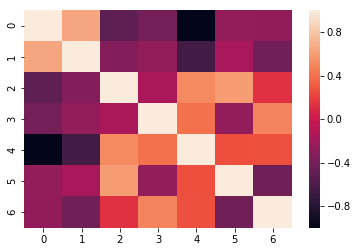

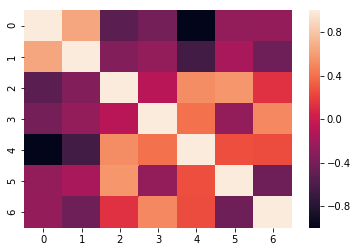

In [71]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

In [72]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

-0.08500121556509133 -0.08421985006833921


# Simple Simulated Examples for Classification

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

We use the popular `train_test_split()` function from `sklearn`, and the data pattern function source code is copied below for your convenience from `lucem_illud`'s [cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py) file.

In [73]:
def random(numPerCategory = 500):
    datDict = {
        'vect' : [np.random.rand(2) * 2 - 1 for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def andSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        y = np.random.random_sample() * 2 - 1
        if noise >= 0:
            x = np.random.random_sample() - cat - (np.random.random_sample() - cat) * noise
        else:
            x = (1 - noise * np.random.random_sample()) - cat
        return np.array([x, y])
    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def xorSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        if cat == 1:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        else:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        return np.array([x, y])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def targetSplit(noise = 0, numPerCategory = 500, innerRad = .3):
    def genPoint(cat):
        if cat == 0:
            r = np.random.random_sample() * innerRad + (1 - innerRad) * np.random.random_sample() * noise
        else:
            r = np.random.random_sample() * (1 - innerRad) + innerRad - innerRad * np.random.random_sample() * noise
        eta = 2 * np.pi * np.random.random_sample()
        return np.array([r * np.cos(eta), r * np.sin(eta)])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def multiBlobs(noise = 0, numPerCategory = 500, centers = 5):
    if isinstance(centers, int):
        n_samples = numPerCategory * centers
    else:
        n_samples = numPerCategory * len(centers)
    X, y = sklearn.datasets.make_blobs(n_samples=n_samples, centers=centers, cluster_std = (.8 * (noise * 2 + 1)))
    datDict = {
        'vect' : list(X),
        'category' : y,
    }
    return pandas.DataFrame(datDict)

In [74]:
noise = .2

#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.random(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.2)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.2)

We can easily visualize the rendered datasets because they are generated in two dimensions.

Let's see what dfTrain, a simulated data that we just made, looks like

In [76]:
dfTrain.head(10)

,vect,category
99,"[0.27002838967850806, 0.3615568592917841]",1
887,"[0.19468468934161545, 0.789493339253996]",1
73,"[0.2469983871384316, -0.6216582771930466]",1
450,"[0.11871728583502464, 0.2519208153430156]",0
569,"[-0.5303431720262872, 0.028230331736569667]",1
944,"[-0.268072008202271, 0.0693087252017121]",0
299,"[0.16648260028470024, 0.863035288632125]",1
81,"[0.032127387553395594, -0.8756085079773904]",1
202,"[-0.26015182070135234, -0.14692357526107]",0
818,"[-0.025128625917341996, -0.028364574991578285]",0


So, dfTrain has two columns, vect and category. We can plot this with `plotter()` from [lucem_illud/lucem_illud/cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py). Here's the source code:

In [77]:
def plotter(df):
    fig, ax = plt.subplots(figsize = (10,10))
    pallet = seaborn.color_palette(palette='rainbow', n_colors= len(set(df['category'])))
    for i, cat in enumerate(set(df['category'])):
        a = np.stack(df[df['category'] == cat]['vect'])
        ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)
    ax.legend(loc = 'center right', title = 'Categories')
    ax.axis('off')
    plt.show()
    plt.close()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


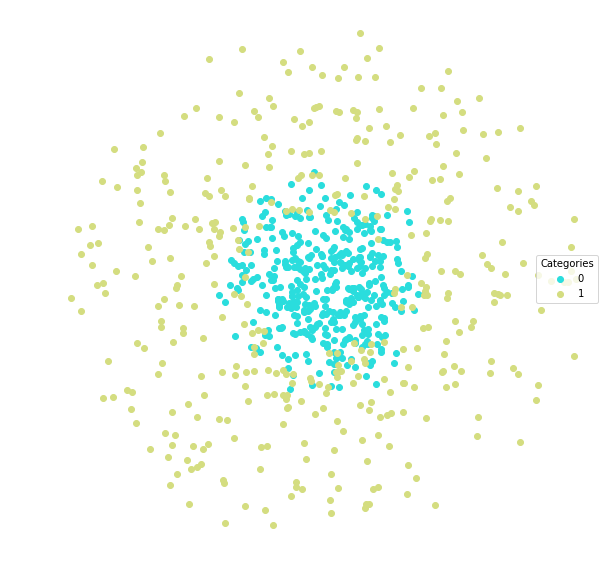

In [78]:
lucem_illud.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [24]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

We're using sklearn here. What is sklearn? It's an open source machine learning library for Python. We use sklearn because it features various machine learning algorithms and it works well with NumPy library. You don't need to understand the sklearn package in detail for the moment, but let's see what methods and attributes sklearn has, because we're going to use some of them:

In [25]:
dir(sklearn)

['__SKLEARN_SETUP__',
 '__all__',
 '__builtins__',
 '__cached__',
 '__check_build',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_config',
 '_distributor_init',
 '_loss',
 'base',
 'clone',
 'config_context',
 'datasets',
 'decomposition',
 'dummy',
 'ensemble',
 'exceptions',
 'externals',
 'feature_extraction',
 'get_config',
 'linear_model',
 'logger',
 'logging',
 'metrics',
 'model_selection',
 'neighbors',
 'neural_network',
 'os',
 'preprocessing',
 'set_config',
 'setup_module',
 'show_versions',
 'svm',
 'sys',
 'tree',
 'utils']

Now we fit the model by giving it our training data

In [79]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

LogisticRegression()

Here, "stack" function is used. Why did we use stack function here? This is because dfTrain['vect'] is a sequence, while clf.fit() takes an array element. Let's see what dfTrain['vect'] looks like:

In [80]:
dfTrain['vect']

99          [0.27002838967850806, 0.3615568592917841]
887          [0.19468468934161545, 0.789493339253996]
73          [0.2469983871384316, -0.6216582771930466]
450         [0.11871728583502464, 0.2519208153430156]
569       [-0.5303431720262872, 0.028230331736569667]
944          [-0.268072008202271, 0.0693087252017121]
299          [0.16648260028470024, 0.863035288632125]
81        [0.032127387553395594, -0.8756085079773904]
202         [-0.26015182070135234, -0.14692357526107]
818    [-0.025128625917341996, -0.028364574991578285]
47          [0.639431836424283, -0.03663026473844313]
368      [-0.26221243166429653, 0.016012536312727015]
895       [-0.42628052373527625, 0.15732461757190105]
469        [0.04167448810152902, -0.6345445906815199]
960       [-0.11280440658909739, -0.0692034872706326]
84         [0.15998755109490254, 0.05861417183327246]
839       [-0.007855588532592788, 0.5058908668573352]
972          [0.10261912317407976, 0.336398604796626]
318        [0.12893069152627

And let's see what np.stack(dfTrain['vect']) does:

In [81]:
np.stack(dfTrain['vect'])

array([[ 0.27002839,  0.36155686],
       [ 0.19468469,  0.78949334],
       [ 0.24699839, -0.62165828],
       ...,
       [-0.11437356, -0.04839177],
       [-0.19905407,  0.44587849],
       [-0.3482177 , -0.00758788]])

As you can see, stack function takes a sequence of arrays (which have the same shape) and joins them along a new axis.

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set. These `lucem_illud` functions are in [metrics.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/metrics.py), and we will skip copying source code this time due to length.

In [82]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.425,0.580529,0.543307,0.525502,0.718750
1,0.425,0.580529,0.630137,0.568714,0.442308


This lets us look at which classes do better:

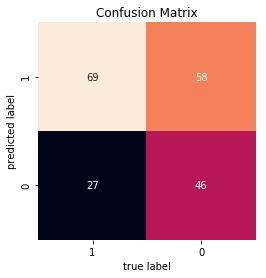

In [83]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

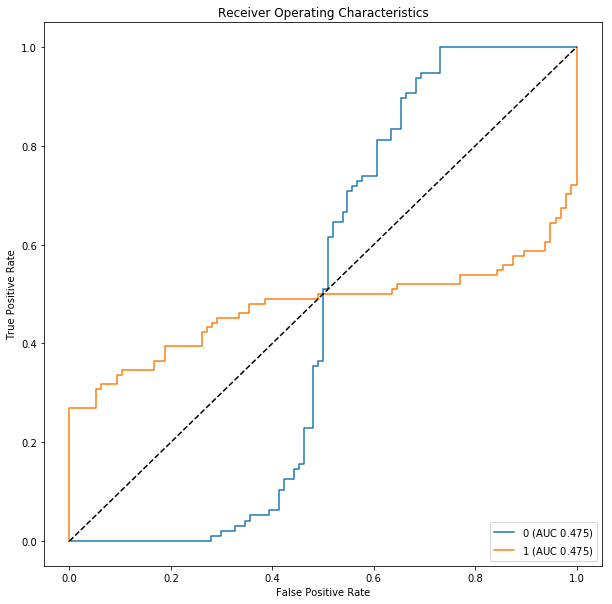

In [84]:
lucem_illud.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


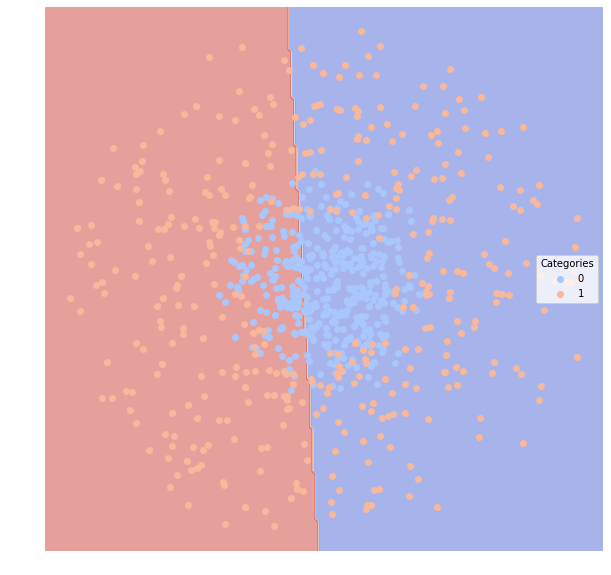

In [85]:
lucem_illud.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

In [86]:
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadReddit(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateSmall(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateLarge(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSpam(), test_size=.2)

Loading Reddit data
Converting to vectors


/opt/anaconda3/lib/python3.7/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [87]:
#Classical Regression
clf = sklearn.linear_model.LogisticRegression()

#Bayes
# clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [88]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

LogisticRegression()

In [89]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Relationships,0.025000,0.971874,0.943182,0.919655,0.965116
Weeaboo Tales,0.006250,0.987805,1.000000,0.981860,0.975610
Bad Roommates,0.003125,0.992958,1.000000,0.989040,0.985915
Tales From Tech Support,0.015625,0.981378,0.963415,0.945877,0.975309


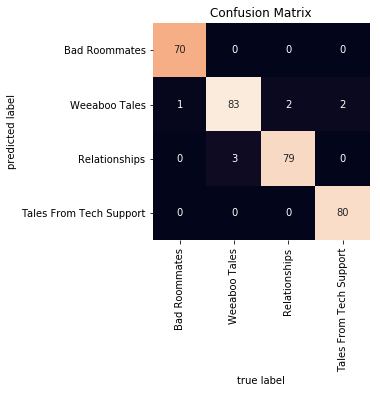

In [90]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

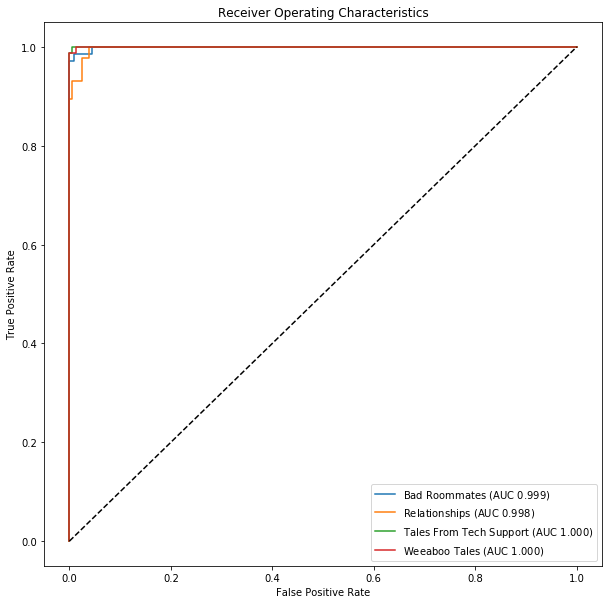

In [91]:
lucem_illud.plotMultiROC(clf, dfTest)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

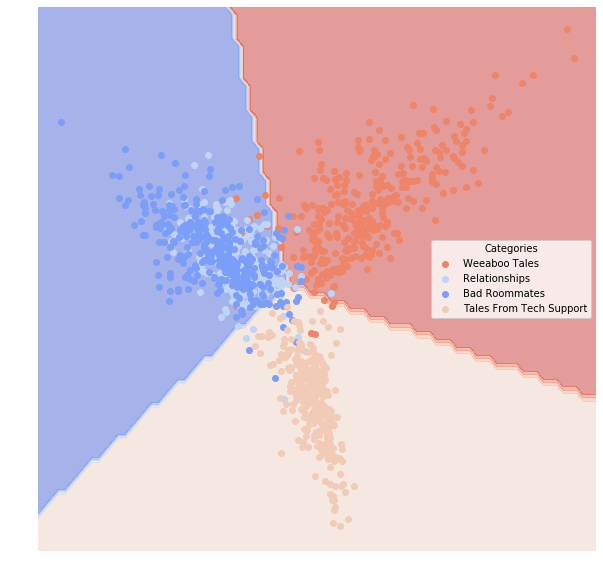

In [92]:
lucem_illud.plotregions(clf, dfTrain)

## <font color="red">*Exercise 2*</font>

<font color="red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<font color="red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

<font color = purple size = 2> I tried to generate 10 artificial datasets and plot them below

In [96]:
#generate 10 distinct artificial datasets:
dfTrain0, dfTest0 = sklearn.model_selection.train_test_split(lucem_illud.random(), test_size=.2)
dfTrain1, dfTest1 = sklearn.model_selection.train_test_split(lucem_illud.random(), test_size=.2)
noise = .2
dfTrain2, dfTest2 = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.2)
dfTrain3, dfTest3 = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.2)
dfTrain4, dfTest4 = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2)
dfTrain5, dfTest5 = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.2)
noise = .5
dfTrain6, dfTest6 = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.2)
dfTrain7, dfTest7 = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.2)
dfTrain8, dfTest8 = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2)
dfTrain9, dfTest9 = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.2)

In [207]:
def plotter(df, ax, num):
    pallet = seaborn.color_palette(palette="rainbow", n_colors= len(set(df['category'])))
    for i, cat in enumerate(set(df['category'])):
        a = np.stack(df[df['category'] == cat]['vect'])
        ax.scatter(a[:,0], a[:, 1], c = np.asarray(pallet)[i].reshape(1,3), label = cat, s = 1)
    #ax.legend(loc = 'center right', title = 'Categories')
    ax.axis('off')
    plt.title('df '+str(num), size = 15)
    

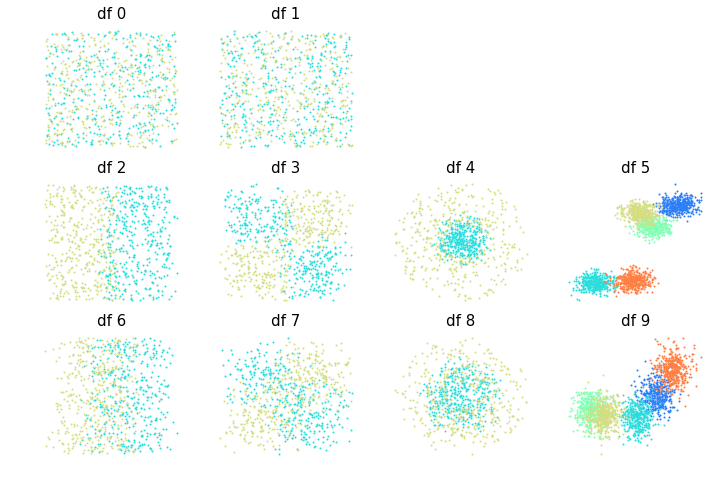

In [208]:
fig = plt.figure(figsize = (12,8))
ax0 = fig.add_subplot(341)
plotter(dfTrain0, ax0, 0)
ax1 = fig.add_subplot(342)
plotter(dfTrain1, ax1, 1)
ax2 = fig.add_subplot(345)
plotter(dfTrain2, ax2, 2)
ax3 = fig.add_subplot(346)
plotter(dfTrain3, ax3, 3)
ax4 = fig.add_subplot(347)
plotter(dfTrain4, ax4, 4)
ax5 = fig.add_subplot(348)
plotter(dfTrain5, ax5, 5)
ax6 = fig.add_subplot(349)
plotter(dfTrain6, ax6, 6)
ax7 = fig.add_subplot(3,4,10)
plotter(dfTrain7, ax7, 7)
ax8 = fig.add_subplot(3,4,11)
plotter(dfTrain8, ax8, 8)
ax9 = fig.add_subplot(3,4,12)
plotter(dfTrain9, ax9, 9)
plt.show()

<font color = purple size = 2> I apply all 9 classifier to the 10 dataset, and pick some to observe.

In [210]:
from sklearn.naive_bayes import GaussianNB
#Bayes
bayes_clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
linsvm_clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
polysvm_clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
knn_clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
logreg_clf = sklearn.linear_model.LogisticRegression()

#Symbolists
dt_clf = sklearn.tree.DecisionTreeClassifier()
rf_clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
nn_clf = sklearn.neural_network.MLPClassifier()

#Ensemble
grad_clf = sklearn.ensemble.GradientBoostingClassifier()

In [243]:
clf_names = ['bayes', 'linsvm', 'polysvm', 'knn', 'logreg', 'dt', 'rf', 'nn', 'grad']
clf_list = [bayes_clf, linsvm_clf, polysvm_clf, knn_clf, logreg_clf, dt_clf, rf_clf, nn_clf, grad_clf]
dfTrain_list = [dfTrain0, dfTrain1, dfTrain2, dfTrain3, dfTrain4, dfTrain5, dfTrain6, dfTrain7, dfTrain8, dfTrain9]
dfTest_list = [dfTest0, dfTest1, dfTest2, dfTest3, dfTest4, dfTest5, dfTrain6, dfTest7, dfTest8, dfTest9]
eva_df = pandas.DataFrame()
for i in range(10):
    dfTrain = dfTrain_list[i]
    dfTest = dfTest_list[i]
    for j, clf in enumerate(clf_list):
        clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
        evaluation = lucem_illud.evaluateClassifier(clf, dfTest)
        evaluation.insert(0, 'df_num', i)
        evaluation.insert(1, 'clf', clf_names[j])
        eva_df = eva_df.append(evaluation)


In [251]:
eva_df.to_csv("artificial_dataset_evaluation.csv")

<font color = purple size = 2> From below we can see all the classifiers work not so great on randomly generated data.

In [246]:
eva_df[eva_df['df_num']==0]

,df_num,clf,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,,,
0,0,bayes,0.430,0.573264,0.611111,0.572086,0.518868
1,0,bayes,0.430,0.573264,0.536364,0.511654,0.627660
0,0,linsvm,0.430,0.571457,0.604167,0.570582,0.547170
1,0,linsvm,0.430,0.571457,0.538462,0.510786,0.595745
0,0,polysvm,0.470,0.542152,0.600000,0.553774,0.339623
1,0,polysvm,0.470,0.542152,0.500000,0.492340,0.744681
0,0,knn,0.535,0.462766,0.495327,0.512664,0.500000
1,0,knn,0.535,0.462766,0.430108,0.453024,0.425532
0,0,logreg,0.420,0.586311,0.637500,0.581722,0.481132


<font color = purple size = 2> We can see all the classifiers work great on and-split data.

In [254]:
eva_df[eva_df['df_num']==2]

,df_num,clf,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,,,
0,2,bayes,0.080,0.920673,0.900000,0.873750,0.937500
1,2,bayes,0.080,0.920673,0.940000,0.899615,0.903846
0,2,linsvm,0.090,0.910256,0.897959,0.863129,0.916667
1,2,linsvm,0.090,0.910256,0.921569,0.882956,0.903846
0,2,polysvm,0.100,0.900641,0.880000,0.846667,0.916667
1,2,polysvm,0.100,0.900641,0.920000,0.873846,0.884615
0,2,knn,0.100,0.901042,0.872549,0.843926,0.927083
1,2,knn,0.100,0.901042,0.928571,0.877500,0.875000
0,2,logreg,0.085,0.915465,0.898990,0.868439,0.927083


<font color = purple size = 2> From below we can see knn, random forest, neural network, and gradient boosting work great on xor-splited data.

In [253]:
eva_df[eva_df['df_num']==4]

,df_num,clf,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,,,
0,4,bayes,0.105,0.894858,0.896907,0.851234,0.887755
1,4,bayes,0.105,0.894858,0.893204,0.855635,0.901961
0,4,linsvm,0.390,0.615246,0.565789,0.556509,0.877551
1,4,linsvm,0.390,0.615246,0.750000,0.594706,0.352941
0,4,polysvm,0.420,0.588235,0.538462,0.538462,1.000000
1,4,polysvm,0.420,0.588235,1.000000,0.596471,0.176471
0,4,knn,0.090,0.909964,0.908163,0.869761,0.908163
1,4,knn,0.090,0.909964,0.911765,0.876315,0.911765
0,4,logreg,0.470,0.530812,0.518519,0.506296,0.571429


<font color = purple size = 2> From below we can see also knn, random forest, neural network, and gradient boosting classifiers work great on target-splited data.

In [247]:
eva_df[eva_df['df_num']==4]

,df_num,clf,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,,,
0,4,bayes,0.105,0.894858,0.896907,0.851234,0.887755
1,4,bayes,0.105,0.894858,0.893204,0.855635,0.901961
0,4,linsvm,0.390,0.615246,0.565789,0.556509,0.877551
1,4,linsvm,0.390,0.615246,0.750000,0.594706,0.352941
0,4,polysvm,0.420,0.588235,0.538462,0.538462,1.000000
1,4,polysvm,0.420,0.588235,1.000000,0.596471,0.176471
0,4,knn,0.090,0.909964,0.908163,0.869761,0.908163
1,4,knn,0.090,0.909964,0.911765,0.876315,0.911765
0,4,logreg,0.470,0.530812,0.518519,0.506296,0.571429


<font color = purple size = 2> Comparing to the upper section, the performance get worse when the noise is larger. We can also see svm and logistic regression perform worse than others.

In [250]:
eva_df[eva_df['df_num']==8]

,df_num,clf,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,,,
0,8,bayes,0.260,0.742768,0.692308,0.658113,0.835052
1,8,bayes,0.260,0.742768,0.807229,0.705091,0.650485
0,8,linsvm,0.450,0.556801,0.524138,0.515665,0.783505
1,8,linsvm,0.450,0.556801,0.618182,0.549060,0.330097
0,8,polysvm,0.425,0.587379,0.532967,0.532967,1.000000
1,8,polysvm,0.425,0.587379,1.000000,0.599757,0.174757
0,8,knn,0.300,0.702132,0.663717,0.623183,0.773196
1,8,knn,0.300,0.702132,0.747126,0.661488,0.631068
0,8,logreg,0.480,0.521369,0.504587,0.496106,0.567010


In [248]:
eva_df[eva_df['df_num']==9]

,df_num,clf,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,,,
0,9,bayes,0.046,0.935026,0.892857,0.826376,0.900901
1,9,bayes,0.032,0.939342,0.960000,0.877333,0.888889
2,9,bayes,0.078,0.870218,0.795699,0.666401,0.787234
3,9,bayes,0.088,0.865042,0.742268,0.625289,0.791209
4,9,bayes,0.024,0.965295,0.928571,0.890208,0.947917
0,9,linsvm,0.048,0.930522,0.891892,0.819471,0.891892
1,9,linsvm,0.032,0.942697,0.950980,0.876121,0.898148
2,9,linsvm,0.084,0.866523,0.770833,0.646826,0.787234
3,9,linsvm,0.094,0.848559,0.734043,0.600582,0.758242


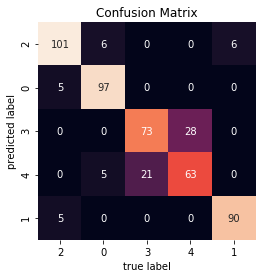

In [249]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

<font color = purple size = 4>Empirical datasets

<font color = purple size = 2>It is impractical to test all datasets and classifiers, so I am only picking some of them, play with them and provide my assumption.

<font color = purple size = 2>NewsGroups dataset: I think neural network will do a beeter job given the high-dimentional vectors with many zeros.

In [258]:
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(), test_size=.2)


Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors


In [265]:
dfTrain.head(2)

,text,category,source_file,tokenized_text,normalized_text,vect
405,\nThe CD300 (external) is already shipping and...,comp.sys.mac.hardware,../data\20news_home\20news-bydate-train\comp.s...,"[The, CD300, external, is, already, shipping, ...","[cd300, external, shipping, shipping, awhile, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
670,"Greetings,\n\nMy question is whether the upcom...",comp.windows.x,../data\20news_home\20news-bydate-train\comp.w...,"[Greetings, My, question, is, whether, the, up...","[greetings, question, upcoming, release, x11r6...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


                       Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                    
comp.sys.mac.hardware    0.038298  0.931246   0.948454           0.858686   
misc.forsale             0.051064  0.921023   0.915888           0.826225   
comp.windows.x           0.023404  0.966203   0.967213           0.927943   
rec.autos                0.061702  0.942850   0.840278           0.813346   

                         Recall  
Category                         
comp.sys.mac.hardware  0.876190  
misc.forsale           0.867257  
comp.windows.x         0.944000  
rec.autos              0.952756  


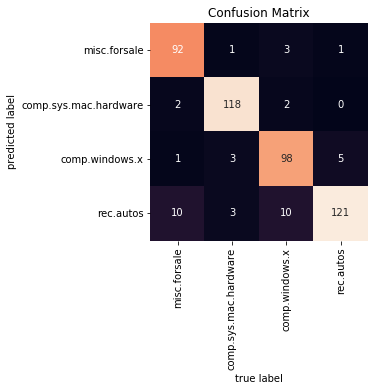

None


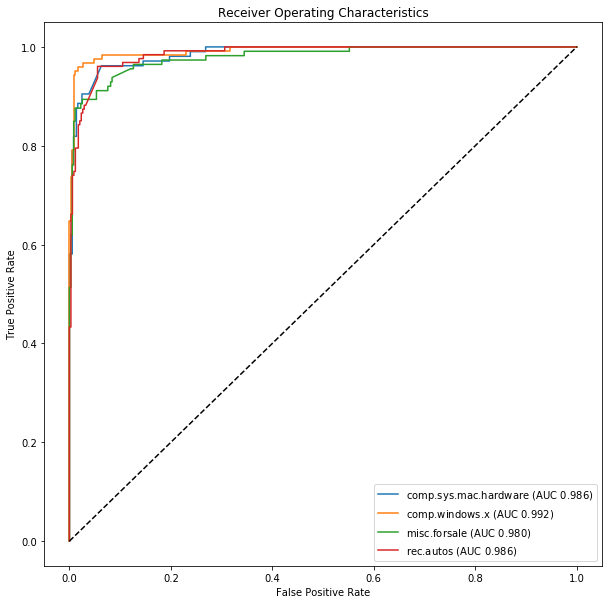

None


In [264]:
#bayes_clf, linsvm_clf, polysvm_clf, knn_clf, logreg_clf, dt_clf, rf_clf, nn_clf, grad_clf
clf = nn_clf
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
print(lucem_illud.evaluateClassifier(clf, dfTest))
print(lucem_illud.plotConfusionMatrix(clf, dfTest))
print(lucem_illud.plotMultiROC(clf, dfTest))
#print(lucem_illud.plotregions(clf, dfTrain))

<font color = purple size = 2>SenateSmall dataset: I think neural network will do a beeter job given the high-dimentional vectors with many zeros. But since it is a binary classification, I think linear svm can also handle this classification task. (It turns out that svm linear out perform neural network.)

In [272]:
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateSmall(), test_size=.2)


Loading senate data
Converting to vectors


In [267]:
dfTrain.head(2)

,download_url,html_url,name,path,text,targetSenator,category,tokenized_text,normalized_text,vect
1304,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,16Mar2006Clinton597.txt,raw/Clinton/16Mar2006Clinton597.txt,March 16 2006 Senator Hillary Rodham Clinton ...,Clinton,Clinton,"[March, 16, 2006, Senator, Hillary, Rodham, Cl...","[march, senator, hillary, rodham, clinton, cal...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
126,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,15May2007Obama406.txt,raw/Obama/15May2007Obama406.txt,Obama Bill Provides Every American with Too...,Obama,Obama,"[Obama, Bill, Provides, Every, American, with,...","[obama, bill, provides, american, tools, fight...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
Obama       0.061404  0.933043   0.939394           0.888266  0.905109
Clinton     0.061404  0.933043   0.938095           0.924878  0.960976


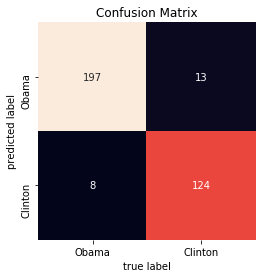

None


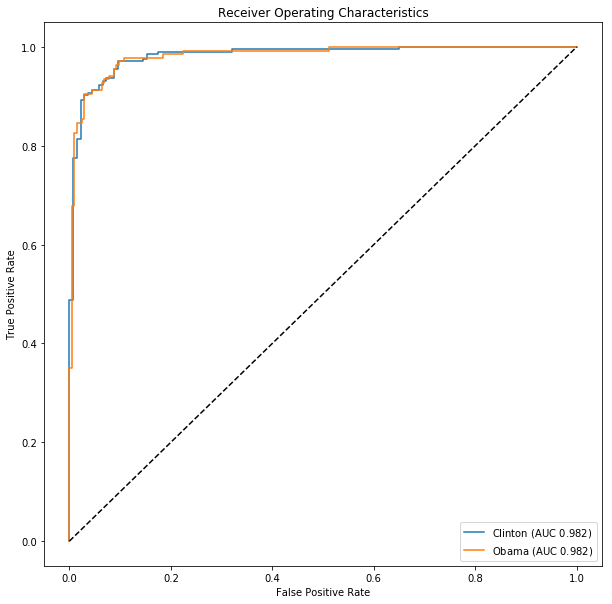

None


In [268]:
#bayes_clf, linsvm_clf, polysvm_clf, knn_clf, logreg_clf, dt_clf, rf_clf, nn_clf, grad_clf
clf = nn_clf
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
print(lucem_illud.evaluateClassifier(clf, dfTest))
print(lucem_illud.plotConfusionMatrix(clf, dfTest))
print(lucem_illud.plotMultiROC(clf, dfTest))
#print(lucem_illud.plotregions(clf, dfTrain))

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
Obama       0.005848  0.993421   1.000000           0.992690  0.986842
Clinton     0.005848  0.993421   0.989583           0.989583  1.000000


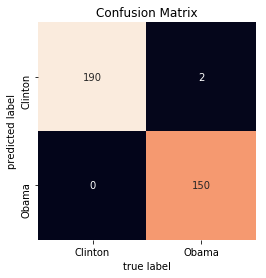

None


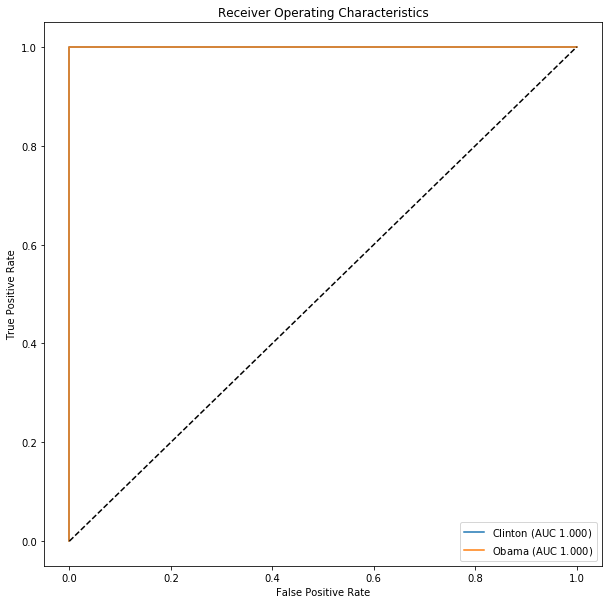

None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


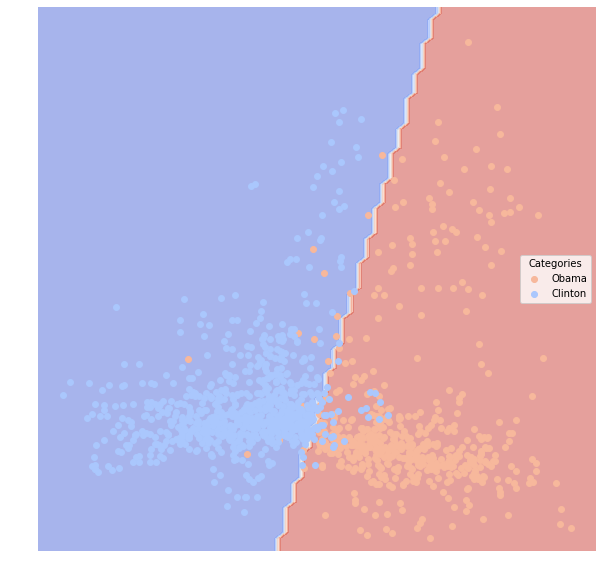

None


In [273]:
#bayes_clf, linsvm_clf, polysvm_clf, knn_clf, logreg_clf, dt_clf, rf_clf, nn_clf, grad_clf
clf = linsvm_clf
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
print(lucem_illud.evaluateClassifier(clf, dfTest))
print(lucem_illud.plotConfusionMatrix(clf, dfTest))
print(lucem_illud.plotMultiROC(clf, dfTest))
print(lucem_illud.plotregions(clf, dfTrain))

<font color = purple size = 2>Spam dataset: It's a binary classification but the categories are unbalanced, I tried all classifiers and find that somehow nn works better. 

In [274]:
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSpam(), test_size=.2)

Loading Spam
Loading Ham
Converting to vectors


In [277]:
from collections import Counter
Counter(dfTrain['category'])

Counter({'not spam': 2340, 'spam': 398})

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
spam        0.083212  0.814368   0.760870           0.558341  0.666667
not spam    0.083212  0.814368   0.940978           0.937403  0.962069


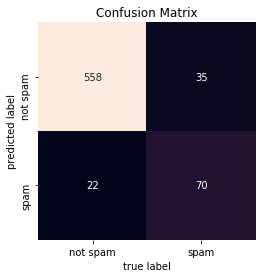

None


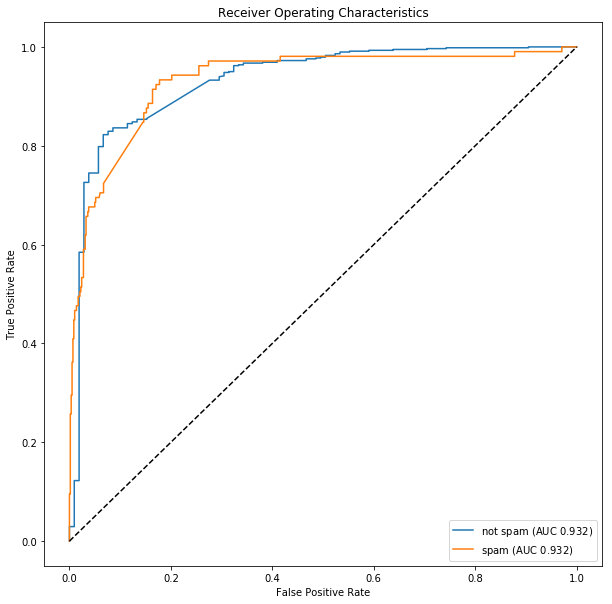

None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


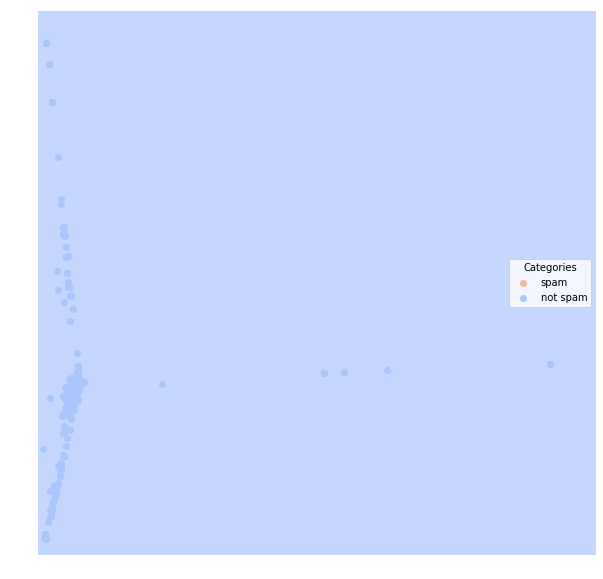

None


In [282]:
#bayes_clf, linsvm_clf, polysvm_clf, knn_clf, logreg_clf, dt_clf, rf_clf, nn_clf, grad_clf
clf = nn_clf
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
print(lucem_illud.evaluateClassifier(clf, dfTest))
print(lucem_illud.plotConfusionMatrix(clf, dfTest))
print(lucem_illud.plotMultiROC(clf, dfTest))
#print(lucem_illud.plotregions(clf, dfTrain))

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [285]:
ObamaClintonReleases = pandas.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

I'm pretty sure that you're all familiar with pandas, but, just to clarify: why do we use pandas here? pandas is a Python library which is widely used for analyzing and wrangling data. In particular, pandas loads data and creates data frame, a Python object that looks familiar to us (since it looks like a excel table) and easy to work with. So, using pandas.read_csv function, we take in the csv file and convert it into a data frame. 

In [286]:
type(ObamaClintonReleases)

pandas.core.frame.DataFrame

It's a DataFrame! and it looks like this:

In [287]:
ObamaClintonReleases

,download_url,html_url,name,path,text,targetSenator
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Obama108.txt,raw/Obama/10Apr2008Obama108.txt,Statement from Senator Barack Obama on the ...,Obama
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama674.txt,raw/Obama/10Aug2005Obama674.txt,Obama Says Bill Will Help Cut Off Supply of...,Obama
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama675.txt,raw/Obama/10Aug2005Obama675.txt,Obama Durbin Say Illinois Will Receive 33 ...,Obama
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Obama508.txt,raw/Obama/10Aug2006Obama508.txt,Obama Introduces Bill to Help Tap Power of ...,Obama
5,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Dec2007Obama192.txt,raw/Obama/10Dec2007Obama192.txt,Statement of Senator Barack Obama on Intern...,Obama
6,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Jan2007Obama472.txt,raw/Obama/10Jan2007Obama472.txt,Legislation to Increase Availability and Us...,Obama
7,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Jan2008Obama165.txt,raw/Obama/10Jan2008Obama165.txt,Obama Statement on the Flooding in East Cen...,Obama
8,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Jul2008Obama28.txt,raw/Obama/10Jul2008Obama28.txt,Obama Green Applaud House Passage of Bill ...,Obama
9,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Jul2008Obama29.txt,raw/Obama/10Jul2008Obama29.txt,Obama Joins Schumer and McCaskill to Call o...,Obama


In [309]:
ObamaClintonReleases['text'][0]

'   Obama Calls on IRS to Protect Taxpayers    Privacy   U S  Senator Barack Obama                       Barack Obama                                                                           Obama Calls on IRS to Protect Taxpayers    Privacy Monday  April  9  2007  FOR IMMEDIATE RELEASE   Contact  Ben LaBolt  Following reports of lax security procedures  asks for investigation  solution WASHINGTON  DC    U S  Senator Barack Obama  D IL  today sent a letter calling on Internal Revenue Service Commissioner Mark Everson to fully account for the loss of computers containing sensitive taxpayer information  to audit vulnerabilities taxpayers face when they turn over personal information to the IRS  and to find a solution that protects taxpayers    privacy   The Washington Post reported last week that an Inspector General report found that    thousands of taxpayers could be at risk of identity theft or other financial fraud because the Internal Revenue Service has failed to adequately protec

Neat! Let's turn the 'targetSenator' column into a binary category variable.

In [288]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [289]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

Let's split the data into training data and testing data.

In [290]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(ObamaClintonReleases, test_size=holdBackFraction)

In [291]:
print(len(train_data_df))
print(len(test_data_df))

1367
342


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud.generateVecs()` will help with this but for now we are doing it the long way):

In [292]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

The core function here is TfidfVectorizer, which takes a collection of raw documents and turn them to a tf-idf matrix. Just to recap: tf-idf means term frequency-inverse document frequency, a statistic (or, more precisely, a product of two statistics, term frequency and inverse document frequency) that shows the importance of a term vis-a-vis documents. TF, or, term frequency, counts how many times a term is used in a document; IDF, or, inverse-document-frequency, measures common or rare a term appears across documents. 

Let's look at three parameters of TfidfVectorizer: max_df = 100, min_df = 2, and norm='l2'. What do those parameters mean? 

(1) max_df = 100

Here, we specified a thredhold of 100, and the terms that have a document frequency higher than 100 would be ignored.

(2) min_df = 2

We specified a lower bound, 2, and the terms that have a document frequency lower than 2 will be ignored.

(3) norm = 'l2'

This parameter is about vector normalization. In machine learning, we commonly normalize vectors, i.e., change the length of vectors and turn them into a unit vector, before passing them into algorithms. There are various ways of normalizations, and this parameter specifies how we normalize vectors. Here, we set the norm to l2, in which case, we normalize the vectors such that squares of vector elements sums to 1. Alternatively, we can set it to l1, in which case the sum of absolute values of vector elements, not the square of vector elements, is 1. 

fit_transform() literally fits to data and then transform it. So, fit_transform() is just a combination of two steps--(1) fitting parameters to data; (2) then, using the vocabulary and document frequencies learned by fit(), transforming documents into document-term matrix. So, it's the same as fit followed by transform. 

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [293]:
TFVects.shape

(1367, 11273)

We can save this in the dataframe to make things easier

In [294]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

Looks simple, but we need to know what todense() does here. todense() returns a dense matrix representation of the matrix. Why do we need this? As you can see above, the TFVects, a document-term matrix, has 11349 columns, and this matrix is sparse, in the sense that it is comprised mostly of zeros. Dense matrices, in contrast, are the matrices that are comprised of mostly non-zeros. Then why do we make sparse matrices into dense ones? Because zero values don't contain important information but take up so much memory.

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [295]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [296]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


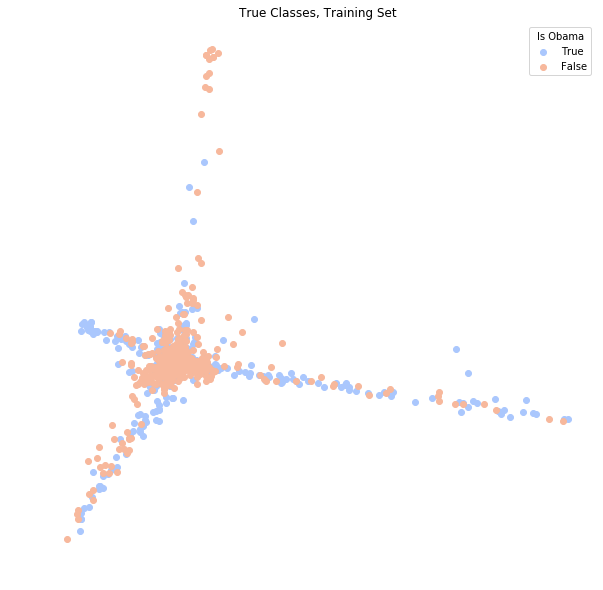

In [297]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

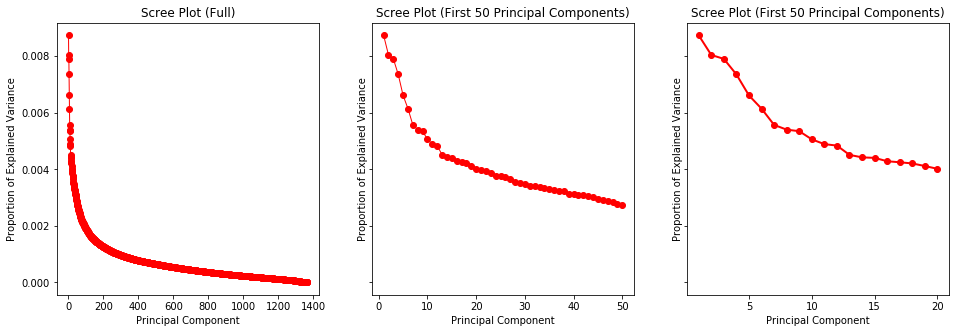

In [298]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [299]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [300]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression()

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [301]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6634967081199707

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [302]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6432748538011696

Slightly poorer. How about using more dimensions (40)?

In [303]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7417702999268471
Testing:
0.7046783625730995


Or still more (100)?

In [304]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8163862472567667
Testing:
0.7748538011695907


Or even more (200)!

In [305]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8771031455742502
Testing:
0.804093567251462


This is becoming ridiculous (400)!

In [306]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9107534747622531
Testing:
0.8216374269005848


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [307]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.9612289685442575


Train the model using training data, and then test it on the testing data.

In [308]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.827485380116959


81% accuracy seems like the best we can get by using a logistic regression.

## <font color="red">*Exercise 3*</font>

<font color="red">In the cells immediately following, perform logistic regression classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk in Exercise 1). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


In [2]:
CR_abstract = pandas.read_csv("/Users/emilyyeh/Documents/SOCI 40133/Homework-Notebooks_v4/week-4/CR_abstract_df.csv")
CR_abstract.head(5)

,year,country,text,abstract,tokenized_abstract,normalized_abstract
0,2020,Angola,EXECUTIVE SUMMARY Angola is a constitutiona...,Angola is a constitutional republic. In Au...,"[['Angola', 'is', 'a', 'constitutional', 'repu...","[['angola', 'constitutional', 'republic'], ['a..."
1,2020,Côte d’Ivoire,EXECUTIVE SUMMARY Cote d’Ivoire is a democr...,Cote d’Ivoire is a democratic republic gov...,"[['Cote', 'd’Ivoire', 'is', 'a', 'democratic',...","[['cote', 'd’ivoire', 'democratic', 'republic'..."
2,2020,Guinea,EXECUTIVE SUMMARY Guinea is a constitutiona...,Guinea is a constitutional democratic repu...,"[['Guinea', 'is', 'a', 'constitutional', 'demo...","[['guinea', 'constitutional', 'democratic', 'r..."
3,2020,Mozambique,EXECUTIVE SUMMARY Mozambique is a multipart...,Mozambique is a multiparty parliamentary d...,"[['Mozambique', 'is', 'a', 'multiparty', 'parl...","[['mozambique', 'multiparty', 'parliamentary',..."
4,2020,South Africa,EXECUTIVE SUMMARY South Africa is a multipa...,South Africa is a multiparty parliamentary...,"[['South', 'Africa', 'is', 'a', 'multiparty', ...","[['south', 'africa', 'multiparty', 'parliament..."


In [61]:
CR_2013_2020 = CR_abstract[CR_abstract['year'] > 2012]
print(CR_2013_2020.shape)
CR_2013_2020.dropna
print(CR_2013_2020.shape)

(1558, 6)
(1558, 6)


In [71]:
FH_2013_2020 = pandas.read_csv('FreedomHouse_2013_2020.csv')

In [75]:
FH_2013_2020 = FH_2013_2020.merge(CR_2013_2020, on = ['country', 'year'])

In [76]:
FH_2013_2020.groupby('status').count()

,country,region,year,text,abstract,tokenized_abstract,normalized_abstract
status,,,,,,,
F,622,622,622,622,622,622,622
NF,354,354,354,354,354,354,354
PF,447,447,447,447,447,447,447


In [79]:
category = []
for status in FH_2013_2020['status']:
    if status == 'F':
        category.append(1)
    else: #PF and NF are 0
        category.append(0)
FH_2013_2020['category'] = category

In [81]:
FH_2013_2020['words'] = FH_2013_2020['normalized_abstract']\
                    .apply(lambda x: ' '.join(re.findall(r'\w+\s?\w+', x)))

In [84]:
train, test = sklearn.model_selection.train_test_split(FH_2013_2020, test_size=.3)

In [85]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train['words'])

In [86]:
TFVects.shape

(996, 6366)

In [88]:
train['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In [90]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train['vect'], axis=0))
train['pca'] = [r for r in reduced_data]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


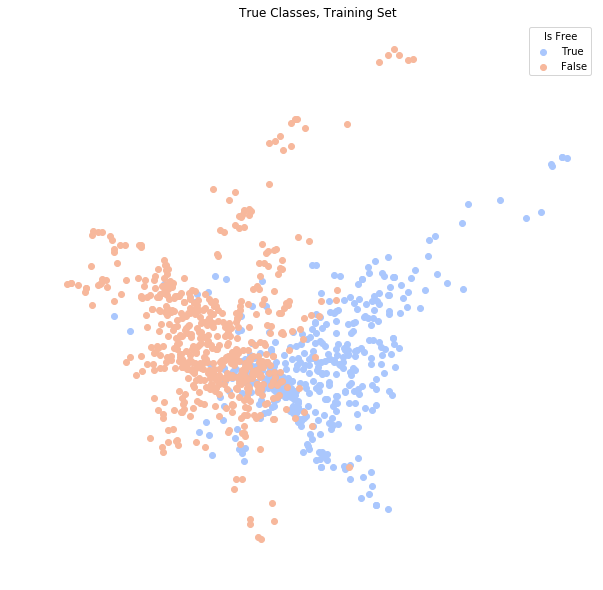

In [92]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Free
a = np.stack(train[train['category'] == 1]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot Partly Free and Not Free
a = np.stack(train[train['category'] == 0]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Free')
plt.title('True Classes, Training Set')
plt.show()

<font color = purple>It actually separated them pretty well!

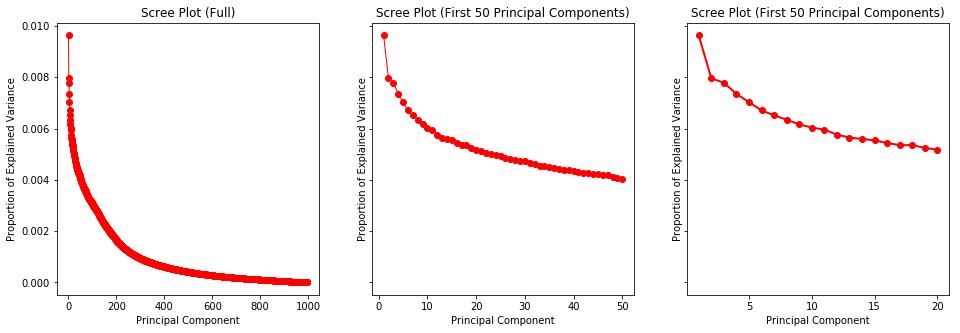

In [93]:
n = len(train)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

In [ ]:
TFVects_test = TFVectorizer.transform(test['text'])
test['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]
reduced_data_test = pca.transform(np.stack(test['vect'], axis=0))
test['pca'] = [r for r in reduced_data_test]

In [105]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train['pca'], axis=0), train['category'])
logistic.score(np.stack(train['pca'], axis=0), train['category'])

0.9879518072289156

In [106]:
logistic.score(np.stack(test['pca'], axis=0), test['category'])

0.5995316159250585

In [97]:
train['pca_reduced_10'] = train['pca'].apply(lambda x: x[:10])
test['pca_reduced_10'] = test['pca'].apply(lambda x: x[:10])

In [108]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train['pca_reduced_10'], axis=0), train['category'])
logistic.score(np.stack(train['pca_reduced_10'], axis=0), train['category'])

0.8815261044176707

In [109]:
logistic.score(np.stack(test['pca_reduced_10'], axis=0), test['category'])

0.5831381733021077

The performance is not that good.

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

In [ ]:
blobs_df = lucem_illud.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = sklearn.model_selection.train_test_split(blobs_df, test_size=.2)
lucem_illud.plotter(df_exampleTree_train)

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [ ]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

To see what's going on visually with the classification: 

In [ ]:
lucem_illud.plotregions(clf_tree, df_exampleTree_train)

In [ ]:
lucem_illud.evaluateClassifier(clf_tree, df_exampleTree_test)

Lets look at accuracy:

In [ ]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

What happens if we trim the tree?

In [ ]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [ ]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [ ]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

In [ ]:
lucem_illud.plotregions(bag, df_exampleTree_test)

In [ ]:
lucem_illud.evaluateClassifier(bag, df_exampleTree_test)

In [ ]:
lucem_illud.plotConfusionMatrix(bag, df_exampleTree_test)

## <font color="red">*Exercise 4*</font>

<font color="red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

In [111]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(train['vect'], axis =0), tree_train['category'])

DecisionTreeClassifier(max_depth=4, random_state=0)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


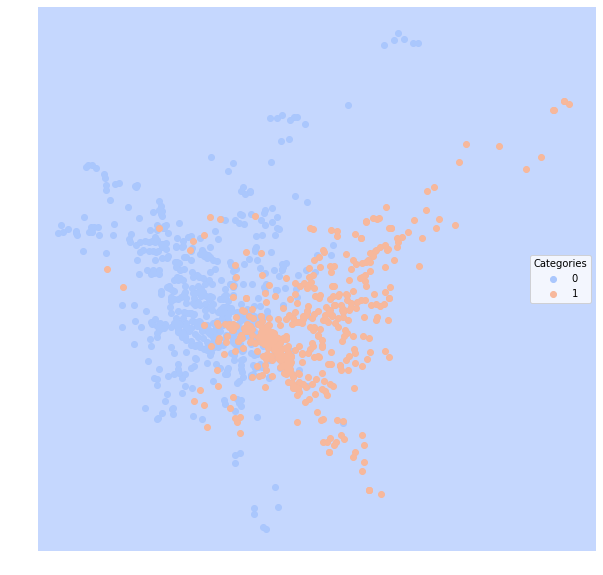

In [112]:
lucem_illud.plotregions(clf_tree, train)

In [113]:
lucem_illud.evaluateClassifier(clf_tree, test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.578454,0.420765,0.492891,0.537954,0.426230
1,0.578454,0.420765,0.351852,0.396710,0.415301


In [120]:
sklearn.metrics.accuracy_score(test['category'],clf_tree.predict(np.stack(test['vect'], axis = 0)))

0.4215456674473068

The performance even worsened T_T.

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data.

In [ ]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus.
newsgroups.target_names #Possible categories, i.e., the newsgroups

target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: lucem_illud.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [ ]:
newsgroupsDF[:5]

Make a testing and training set:

In [ ]:
holdBackFraction = .2
train_ng_df, test_ng_df = sklearn.model_selection.train_test_split(newsgroupsDF, test_size=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [ ]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [ ]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [ ]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

And lets look at the testing data

In [ ]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Let's produce another confusion matrix:

In [ ]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [ ]:
#lucem_illud.plotregions(clf_knearest, test_ng_df)

## <font color="red">*Exercise 5*</font>

<font color="red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

In [115]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train['words'])
train['tfidf_vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [117]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
clf_knearest.fit(np.stack(train['tfidf_vect'], axis = 0), train['category'])

KNeighborsClassifier(n_neighbors=15)

In [119]:
lucem_illud.evaluateClassifier(clf_knearest, train)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.063253,0.934519,0.934859,0.917326,0.953321
1,0.063253,0.934519,0.939252,0.897238,0.915718


In [123]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test['words'])
test['tfidf_vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test['knn_predict'] = clf_knearest.predict(np.stack(test['tfidf_vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test['tfidf_vect'], axis=0), test['category']))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Testing score:
0.9039812646370023


knn is doing a very good job at separating free countries and partly/not free countries!

But probabily because of the tfidf vectorization.

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [ ]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

We will tf.idf the data to make our vectors:

In [ ]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [ ]:
holdBackFraction = .2
train_redditDf, test_redditDf = sklearn.model_selection.train_test_split(redditDf, test_size=holdBackFraction)

In [ ]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

...and consider the results:

In [ ]:
lucem_illud.evaluateClassifier(clf_svm, test_redditDf)

In [ ]:
lucem_illud.plotConfusionMatrix(clf_svm, test_redditDf)

In [ ]:
lucem_illud.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [ ]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf_nn, test_redditDf)

In [ ]:
lucem_illud.plotConfusionMatrix(clf_nn, test_redditDf)

In [ ]:
lucem_illud.plotregions(clf_nn, test_redditDf)

It performs very well.

## <font color="red">*Exercise 6*</font>

<font color="red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, logistic and decision-tree approaches?

In [137]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train['vect'], axis=0), train['category'])

MLPClassifier()

In [138]:
lucem_illud.evaluateClassifier(clf_nn, test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.407494,0.52459,0.583732,0.583732,1.00000
1,0.407494,0.52459,1.000000,0.456674,0.04918


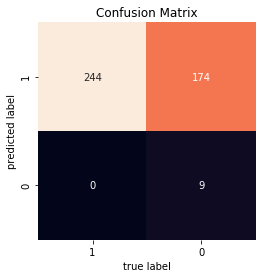

In [139]:
lucem_illud.plotConfusionMatrix(clf_nn, test)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


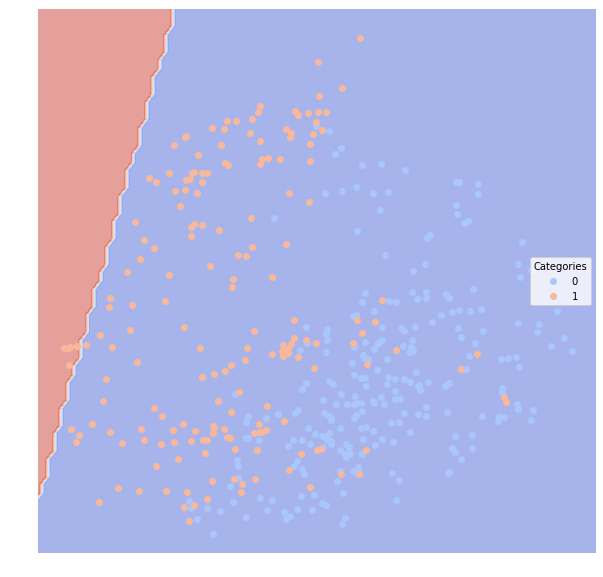

In [140]:
lucem_illud.plotregions(clf_nn, test)

NN networks perform the worse, which is surprising to me. It seems that for nn, either count vectorizer and tfidf vectorizer failed to provide information of categorization.

## Classification with BERT Pipelines
Now, instead of classifying based on "old" NLP methods, we will now use the popular Transformers package default 'pipelines'. This package has methods for a wide range of common NLP tasks using contextual word embeddings. Note that for this homework, we are not building new contextual models ourselves, merely using existing models in Transformers. We will spend Weeks 7 and 8 learning more about Transformers, so do not worry about fully understanding them this week.

[Transformers Documentation](https://huggingface.co/transformers/)

[Transformers GitHub](https://github.com/huggingface/transformers)

The following sections of code are taken from the [Summary of Tasks](https://huggingface.co/transformers/task_summary.html) page in the Transformers documentation.

### Sequence Classification (e.g., sentiment)
Sequence classification is the task of classifying sequences according to a given number of classes. An example of
sequence classification is the GLUE dataset. If you would like to fine-tune a
model on a GLUE sequence classification task, you may leverage the [run_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_glue.py) and
[run_pl_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_pl_glue.py) or
[run_tf_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_tf_glue.py) scripts.

Here is an example of using pipelines to do sentiment analysis: identifying if a sentence is positive or negative. It
leverages a fine-tuned model on sst2, which is a GLUE task.

This returns a label ("POSITIVE" or "NEGATIVE") alongside a score, as follows:

In [141]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis")
result = nlp("I hate you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")
result = nlp("I love you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
/opt/anaconda3/lib/python3.7/site-packages/cryptography/hazmat/backends/openssl/x509.py:17: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,


label: NEGATIVE, with score: 0.9991
label: POSITIVE, with score: 0.9999


Here is an example of doing a sequence classification using a model to determine if two sequences are paraphrases of
each other. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Build a sequence from the two sentences, with the correct model-specific separators token type ids and attention
   masks (`PreTrainedTokenizer.encode` and `PreTrainedTokenizer.__call__` take
   care of this).
3. Pass this sequence through the model so that it is classified in one of the two available classes: 0 (not a
   paraphrase) and 1 (is a paraphrase).
4. Compute the softmax of the result to get probabilities over the classes.
5. Print the results.

In [143]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")
classes = ["not paraphrase", "is paraphrase"]
sequence_0 = "The company HuggingFace is based in New York City"
sequence_1 = "Apples are especially bad for your health"
sequence_2 = "HuggingFace's headquarters are situated in Manhattan"
paraphrase = tokenizer(sequence_0, sequence_2, return_tensors="pt")
not_paraphrase = tokenizer(sequence_0, sequence_1, return_tensors="pt")
paraphrase_classification_logits = model(**paraphrase).logits
not_paraphrase_classification_logits = model(**not_paraphrase).logits
paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]
not_paraphrase_results = torch.softmax(not_paraphrase_classification_logits, dim=1).tolist()[0]
# Should be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(paraphrase_results[i] * 100))}%")
# Should not be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(not_paraphrase_results[i] * 100))}%")

### Extractive Question Answering

Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune a
model on a SQuAD task, you may leverage the [run_squad.py](https://github.com/huggingface/transformers/tree/master/examples/question-answering/run_squad.py) and
[run_tf_squad.py](https://github.com/huggingface/transformers/tree/master/examples/question-answering/run_tf_squad.py) scripts.


Here is an example of using pipelines to do question answering: extracting an answer from a text given a question. It
leverages a fine-tuned model on SQuAD.

In [ ]:
from transformers import pipeline
nlp = pipeline("question-answering")
context = r"""
Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune
a model on a SQuAD task, you may leverage the examples/question-answering/run_squad.py script.
"""

This returns an answer extracted from the text, a confidence score, alongside "start" and "end" values, which are the
positions of the extracted answer in the text.

In [ ]:
result = nlp(question="What is extractive question answering?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")
result = nlp(question="What is a good example of a question answering dataset?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Here is an example of question answering using a model and a tokenizer. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Define a text and a few questions.
3. Iterate over the questions and build a sequence from the text and the current question, with the correct
   model-specific separators token type ids and attention masks.
4. Pass this sequence through the model. This outputs a range of scores across the entire sequence of tokens (question and
   text), for both the start and end positions.
5. Compute the softmax of the result to get probabilities over the tokens.
6. Fetch the tokens from the identified start and stop values, convert those tokens to a string.
7. Print the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
text = r"""
🤗 Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
TensorFlow 2.0 and PyTorch.
"""
questions = [
    "How many pretrained models are available in 🤗 Transformers?",
    "What does 🤗 Transformers provide?",
    "🤗 Transformers provides interoperability between which frameworks?",
]
for question in questions:
    inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    outputs = model(**inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    answer_start = torch.argmax(
        answer_start_scores
    )  # Get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    print(f"Question: {question}")
    print(f"Answer: {answer}")

## <font color="red">*Exercise 7*</font>

<font color="red">In the cells immediately following, use the pipeline functions or the word or sentence vector functions (e.g., similarity) to explore the social game underlying the production and meaning of texts associated with your final project. How does BERT help you gain insight regarding your research question that is similar and different from prior methods?

In [144]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch

In [147]:
FH_2013_2020

,country,region,year,status,text,abstract,tokenized_abstract,normalized_abstract,category,words
0,Afghanistan,Asia,2020,NF,EXECUTIVE SUMMARY Afghanistan is an Islamic...,Afghanistan is an Islamic republic with a ...,"[['Afghanistan', 'is', 'an', 'Islamic', 'repub...","[['afghanistan', 'islamic', 'republic', 'direc...",0,afghanistan islamic republic directly elected ...
1,Albania,Europe,2020,PF,EXECUTIVE SUMMARY The Republic of Albania i...,The Republic of Albania is a parliamentary...,"[['The', 'Republic', 'of', 'Albania', 'is', 'a...","[['republic', 'albania', 'parliamentary', 'dem...",0,republic albania parliamentary democracy const...
2,Algeria,MENA,2020,NF,Executive Summary Algeria is a multiparty r...,Executive Summary Algeria is a multiparty r...,"[['Executive', 'Summary', 'Algeria', 'is', 'a'...","[['executive', 'summary', 'algeria', 'multipar...",0,executive summary algeria multiparty republic ...
3,Andorra,Europe,2020,F,EXECUTIVE SUMMARY The Principality of Andor...,The Principality of Andorra is a constitut...,"[['The', 'Principality', 'of', 'Andorra', 'is'...","[['principality', 'andorra', 'constitutional',...",1,principality andorra constitutional parliament...
4,Angola,SSA,2020,NF,EXECUTIVE SUMMARY Angola is a constitutiona...,Angola is a constitutional republic. In Au...,"[['Angola', 'is', 'a', 'constitutional', 'repu...","[['angola', 'constitutional', 'republic'], ['a...",0,angola constitutional republic august ruling p...
5,Antigua and Barbuda,Americas,2020,F,EXECUTIVE SUMMARY Antigua and Barbuda is a ...,Antigua and Barbuda is a multiparty parlia...,"[['Antigua', 'and', 'Barbuda', 'is', 'a', 'mul...","[['antigua', 'barbuda', 'multiparty', 'parliam...",1,antigua barbuda multiparty parliamentary democ...
6,Argentina,Americas,2020,F,EXECUTIVE SUMMARY Argentina is a federal co...,Argentina is a federal constitutional repu...,"[['Argentina', 'is', 'a', 'federal', 'constitu...","[['argentina', 'federal', 'constitutional', 'r...",1,argentina federal constitutional republic octo...
7,Armenia,Eurasia,2020,PF,Executive Summary Armenia’s constitution pr...,Executive Summary Armenia’s constitution pr...,"[['Executive', 'Summary', 'Armenia', '’s', 'co...","[['executive', 'summary', 'armenia', 'constitu...",0,executive summary armenia constitution provide...
8,Australia,Asia,2020,F,EXECUTIVE SUMMARY Australia is a constituti...,Australia is a constitutional democracy wi...,"[['Australia', 'is', 'a', 'constitutional', 'd...","[['australia', 'constitutional', 'democracy', ...",1,australia constitutional democracy freely elec...
9,Austria,Europe,2020,F,EXECUTIVE SUMMARY The Republic of Austria i...,The Republic of Austria is a parliamentary...,"[['The', 'Republic', 'of', 'Austria', 'is', 'a...","[['republic', 'austria', 'parliamentary', 'dem...",1,republic austria parliamentary democracy const...


In [150]:
text = ' '.join(FH_2013_2020['text'])
questions = [
    "What is the human right situation in China?",
    "What is human rights violation?",
    "Which countries need to improve their human rights protection?",
]

In [ ]:
for question in questions:
    inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    outputs = model(**inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    answer_start = torch.argmax(
        answer_start_scores
    )  # Get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    print(f"Question: {question}")
    print(f"Answer: {answer}")